# Machine Learning Models For Motion Intention Using EMG Signals

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean
import math
from utils import *
from mlModels import *

from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
import sklearn.feature_selection as fs
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor

import keras
import tensorflow as tf
from keras.models import load_model

In [84]:
keras.backend.clear_session()
print("GPUs Available: ", tf.config.list_physical_devices('GPU'))
print(tf.test.is_built_with_cuda())

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True


## Load Data

In [85]:
w_length = 200
w_increment = 100

path = 'D:\Documentos\Datasets\Grabaciones 2 Corr'

raw_data, labels, angle, speed, torque = loadAndLabel(path, w_length, w_increment)

10_ext_0_31_62.txt
10_flex_0_31_62.txt
10_flex_1333_31_62.txt
10_flex_3638_31_62.txt
10_pron_0_4_62.txt
10_pron_919_4_62.txt
10_stat_0_31_62.txt
10_sup_0_4_62.txt
10_sup_919_4_62.txt
11_ext_0_29_48.txt
11_flex_0_29_48.txt
11_flex_1333_29_48.txt
11_flex_3638_29_48.txt
11_pron_0_3_48.txt
11_pron_919_3_48.txt
11_stat_0_29_48.txt
11_sup_0_3_48.txt
11_sup_919_3_48.txt
12_ext_0_31_66.txt
12_flex_0_31_66.txt
12_flex_1333_31_66.txt
12_flex_3638_31_66.txt
12_pron_0_5_66.txt
12_pron_919_5_66.txt
12_sup_0_5_66.txt
12_sup_919_5_66.txt
13_ext_0_31_70.txt
13_flex_0_31_70.txt
13_flex_1333_31_70.txt
13_flex_3638_31_70.txt
13_pron_0_5_70.txt
13_pron_919_5_70.txt
13_stat_0_5_70.txt
13_sup_0_5_70.txt
13_sup_919_5_70.txt
14_ext_0_29_4.txt
14_flex_0_29_4.txt
14_flex_1333_29_4.txt
14_flex_3638_29_4.txt
14_pron_0_4_48.txt
14_pron_919_4_48.txt
14_stat_0_4_48.txt
14_sup_919_4_48.txt
15_ext_0_29_54.txt
15_flex_0_29_54.txt
15_flex_1333_29_54.txt
15_flex_3638_29_54.txt
15_pron_0_4_54.txt
15_pron_919_4_54.txt
15_s

In [86]:
w, ch = raw_data[0].shape
print('Number of examples (m) = ', len(raw_data))
print('Window lenght (w) = ', w)
print('Number of EMG channels (ch) = ', ch)

Number of examples (m) =  22600
Window lenght (w) =  200
Number of EMG channels (ch) =  4


In [87]:
emg_raw_arr = np.array(raw_data)[:,:,0:4]
labels_arr = np.array(labels)
angle_arr = np.array(angle)
speed_arr = np.array(speed)
torque_arr = np.array(torque)
print(emg_raw_arr.shape)

(22600, 200, 4)


## EMG Features

In [88]:
f_emg_data = EMGfeatures(emg_raw_arr)

sc = MinMaxScaler()
trans = sc.fit_transform(f_emg_data)

print(f_emg_data.shape)

c:\Users\alejo\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\signal\_spectral_py.py:1999: UserWarning: nperseg = 256 is greater than input length  = 200, using nperseg = 200
  warnings.warn('nperseg = {0:d} is greater than input length '


(22600, 44)


## Moving Average Filter

In [89]:
maf_emg_data = maf(emg_raw_arr)

ascol = maf_emg_data.reshape(-1, ch)
sc = MinMaxScaler()
trans = sc.fit_transform(ascol)

maf_emg_data = trans.reshape(-1, w, ch)
print(maf_emg_data.shape)

maf_emg_data_flat = maf_emg_data.reshape(maf_emg_data.shape[0], w*ch)
print(maf_emg_data_flat.shape)

(22600, 200, 4)
(22600, 800)


## Autoencoder Feature Extraction

In [90]:
cnn_encoder = load_model('encoder_model.h5')
cnn_encoder.summary()

Model: "Convolutional_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 200, 4, 16)        272       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 100, 2, 16)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 100, 2, 8)         520       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 50, 1, 8)         0         
 2D)                                                             
                                                                 
Total params: 792
Trainable params: 792
Non-trainable params: 0
_________________________________________________________________


In [91]:
cnn_encoder.compile(optimizer='adam', loss='binary_crossentropy')
ae_emg = cnn_encoder.predict(emg_raw_arr)
print(ae_emg.shape)

ae_emg_data = ae_emg.reshape(ae_emg.shape[0], ae_emg.shape[1], ae_emg.shape[3])
print(ae_emg_data.shape)

ae_emg_data_flat = ae_emg.reshape(ae_emg.shape[0], -1)
print(ae_emg_data_flat.shape)

707/707 [==============================] - 1s 1ms/step
(22600, 50, 1, 8)
(22600, 50, 8)
(22600, 400)


In [92]:
_, _, Y_train_labels, Y_test_labels = train_test_split(f_emg_data, labels_arr, stratify=labels, test_size=0.1, random_state=1)

X_train_feat, X_test_feat, Y_train_feat, Y_test_feat = train_test_split(f_emg_data, torque_arr, stratify=labels, test_size=0.1, random_state=1)

X_train_maf, X_test_maf, Y_train_maf, Y_test_maf = train_test_split(maf_emg_data, torque_arr, stratify=labels, test_size=0.1, random_state=1)
X_train_maf_flat, X_test_maf_flat, Y_train_maf_flat, Y_test_maf_flat = train_test_split(maf_emg_data_flat, torque_arr, stratify=labels, test_size=0.1, random_state=1)

X_train_ae, X_test_ae, Y_train_ae, Y_test_ae = train_test_split(ae_emg_data, torque_arr, stratify=labels, test_size=0.1, random_state=1)
X_train_ae_flat, X_test_ae_flat, Y_train_ae_flat, Y_test_ae_flat = train_test_split(ae_emg_data_flat, torque_arr, stratify=labels, test_size=0.1, random_state=1)

# Torque Regression Training

## EMG Features

In [38]:
models_reg, models_names_reg = sklearnModelsReg()
train_scores, val_scores = cvRegression(X_train_feat, Y_train_feat, Y_train_labels, models_reg, k=5)

c:\Users\alejo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\alejo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [39]:
mlp_train_scores, mlp_val_scores = cvKerasReg(X_train_feat, Y_train_feat, Y_train_labels, mlpReg(), k = 5)
models_names_reg.append('Deep MLP')
train_scores[0].append(mlp_train_scores[0])
train_scores[1].append(mlp_train_scores[1])
train_scores[2].append(mlp_train_scores[2])
val_scores[0].append(mlp_val_scores[0])
val_scores[1].append(mlp_val_scores[1])
val_scores[2].append(mlp_val_scores[2])

Epoch 1/200
64/64 [==============================] - 0s 3ms/step - loss: 10.1151 - mean_absolute_error: 2.2053 - mean_squared_error: 10.1151
Epoch 2/200
64/64 [==============================] - 0s 3ms/step - loss: 7.4768 - mean_absolute_error: 1.8035 - mean_squared_error: 7.4768
Epoch 3/200
64/64 [==============================] - 0s 3ms/step - loss: 6.9725 - mean_absolute_error: 1.7198 - mean_squared_error: 6.9725
Epoch 4/200
64/64 [==============================] - 0s 2ms/step - loss: 6.6578 - mean_absolute_error: 1.6771 - mean_squared_error: 6.6578
Epoch 5/200
64/64 [==============================] - 0s 2ms/step - loss: 6.5302 - mean_absolute_error: 1.6778 - mean_squared_error: 6.5302
Epoch 6/200
64/64 [==============================] - 0s 2ms/step - loss: 6.4569 - mean_absolute_error: 1.6812 - mean_squared_error: 6.4569
Epoch 7/200
64/64 [==============================] - 0s 2ms/step - loss: 6.2803 - mean_absolute_error: 1.6546 - mean_squared_error: 6.2803
Epoch 8/200
64/64 [======

In [40]:
cols = pd.MultiIndex.from_product([['Train', 'Val'], ['MAE', 'MSE', 'R2']],names=['','Model'])
models_comparison_reg = pd.DataFrame(zip(train_scores[0], train_scores[1], train_scores[2], val_scores[0], val_scores[1], val_scores[2]), index=models_names_reg, columns=cols)
models_comparison_reg = models_comparison_reg.sort_values([('Val', 'MAE')], ascending=True)
models_comparison_reg


Train                           Val                    
Model                   MAE       MSE        R2       MAE       MSE        R2
Random Forest      0.444598  0.598127  0.948745  1.205181  4.319716  0.629781
Bagging            0.491291  0.854259  0.926796  1.268528  4.812829  0.587456
Deep MLP           1.247420  4.324641  0.629380  1.298961  4.697651  0.597639
Gradient Boosting  1.282433  4.424165  0.620887  1.345308  4.906728  0.579409
MLP                1.397190  4.691032  0.598000  1.441291  4.983424  0.572891
Stacking           0.859272  1.898964  0.837261  1.461543  5.804629  0.502482
SVM                1.500300  7.311839  0.373430  1.504220  7.327799  0.371886
Decision Tree      0.000000  0.000000  1.000000  1.517643  8.714237  0.252732
KNN                1.279693  4.532469  0.611610  1.586870  6.872885  0.410988
Linear Regression  1.644775  6.138977  0.473945  1.650138  6.181367  0.470185
AdaBoost           1.844205  6.698351  0.425959  1.856617  6.849177  0.413087

## Moving Average Filter

In [ ]:
train_scores = [[],[],[]]
val_scores = [[],[],[]]
models_names_reg = []

In [ ]:
mlp_train_scores, mlp_val_scores = cvKerasReg(X_train_maf_flat, Y_train_maf_flat, Y_train_labels, mlpReg(), k = 5)
models_names_reg.append('Deep MLP')
train_scores[0].append(mlp_train_scores[0])
train_scores[1].append(mlp_train_scores[1])
train_scores[2].append(mlp_train_scores[2])
val_scores[0].append(mlp_val_scores[0])
val_scores[1].append(mlp_val_scores[1])
val_scores[2].append(mlp_val_scores[2])

Epoch 1/200
64/64 [==============================] - 1s 3ms/step - loss: 9.7268 - mean_absolute_error: 1.9739 - mean_squared_error: 9.7268
Epoch 2/200
64/64 [==============================] - 0s 3ms/step - loss: 6.4555 - mean_absolute_error: 1.7624 - mean_squared_error: 6.4555
Epoch 3/200
64/64 [==============================] - 0s 3ms/step - loss: 6.3041 - mean_absolute_error: 1.6860 - mean_squared_error: 6.3041
Epoch 4/200
64/64 [==============================] - 0s 2ms/step - loss: 6.1967 - mean_absolute_error: 1.6462 - mean_squared_error: 6.1967
Epoch 5/200
64/64 [==============================] - 0s 3ms/step - loss: 6.0706 - mean_absolute_error: 1.6170 - mean_squared_error: 6.0706
Epoch 6/200
64/64 [==============================] - 0s 2ms/step - loss: 5.9236 - mean_absolute_error: 1.5957 - mean_squared_error: 5.9236
Epoch 7/200
64/64 [==============================] - 0s 2ms/step - loss: 5.7685 - mean_absolute_error: 1.5856 - mean_squared_error: 5.7685
Epoch 8/200
64/64 [========

In [ ]:
cnn_train_scores, cnn_val_scores = cvKerasReg(X_train_maf.reshape(X_train_maf.shape[0],w,ch,1), Y_train_maf, Y_train_labels, cnnReg(), k = 5)
models_names_reg.append('CNN')
train_scores[0].append(cnn_train_scores[0])
train_scores[1].append(cnn_train_scores[1])
train_scores[2].append(cnn_train_scores[2])
val_scores[0].append(cnn_val_scores[0])
val_scores[1].append(cnn_val_scores[1])
val_scores[2].append(cnn_val_scores[2])

Epoch 1/200
64/64 [==============================] - 2s 7ms/step - loss: 11.1208 - mean_absolute_error: 2.2154 - mean_squared_error: 11.1208
Epoch 2/200
64/64 [==============================] - 0s 5ms/step - loss: 6.6375 - mean_absolute_error: 1.7207 - mean_squared_error: 6.6375
Epoch 3/200
64/64 [==============================] - 0s 5ms/step - loss: 6.2804 - mean_absolute_error: 1.6158 - mean_squared_error: 6.2804
Epoch 4/200
64/64 [==============================] - 0s 5ms/step - loss: 6.1348 - mean_absolute_error: 1.5859 - mean_squared_error: 6.1348
Epoch 5/200
64/64 [==============================] - 0s 5ms/step - loss: 6.0043 - mean_absolute_error: 1.5710 - mean_squared_error: 6.0043
Epoch 6/200
64/64 [==============================] - 0s 5ms/step - loss: 5.8692 - mean_absolute_error: 1.5607 - mean_squared_error: 5.8692
Epoch 7/200
64/64 [==============================] - 0s 5ms/step - loss: 5.7226 - mean_absolute_error: 1.5325 - mean_squared_error: 5.7226
Epoch 8/200
64/64 [======

In [ ]:
lstm_train_scores, lstm_val_scores = cvKerasReg(X_train_maf, Y_train_maf, Y_train_labels, lstm_rnnReg(), k = 5)
models_names_reg.append('LSTM')
train_scores[0].append(lstm_train_scores[0])
train_scores[1].append(lstm_train_scores[1])
train_scores[2].append(lstm_train_scores[2])
val_scores[0].append(lstm_val_scores[0])
val_scores[1].append(lstm_val_scores[1])
val_scores[2].append(lstm_val_scores[2])

Epoch 1/200
64/64 [==============================] - 3s 16ms/step - loss: 13.1266 - mean_absolute_error: 2.2007 - mean_squared_error: 13.1266
Epoch 2/200
64/64 [==============================] - 1s 14ms/step - loss: 8.9211 - mean_absolute_error: 2.0641 - mean_squared_error: 8.9211
Epoch 3/200
64/64 [==============================] - 1s 14ms/step - loss: 6.5770 - mean_absolute_error: 1.6518 - mean_squared_error: 6.5770
Epoch 4/200
64/64 [==============================] - 1s 14ms/step - loss: 6.2547 - mean_absolute_error: 1.6434 - mean_squared_error: 6.2547
Epoch 5/200
64/64 [==============================] - 1s 14ms/step - loss: 6.1491 - mean_absolute_error: 1.5840 - mean_squared_error: 6.1491
Epoch 6/200
64/64 [==============================] - 1s 14ms/step - loss: 5.7788 - mean_absolute_error: 1.5638 - mean_squared_error: 5.7788
Epoch 7/200
64/64 [==============================] - 1s 14ms/step - loss: 5.6496 - mean_absolute_error: 1.5349 - mean_squared_error: 5.6496
Epoch 8/200
64/64 

In [ ]:
gru_train_scores, gru_val_scores = cvKerasReg(X_train_maf, Y_train_maf, Y_train_labels, gru_rnnReg(), k = 5)
models_names_reg.append('GRU')
train_scores[0].append(gru_train_scores[0])
train_scores[1].append(gru_train_scores[1])
train_scores[2].append(gru_train_scores[2])
val_scores[0].append(gru_val_scores[0])
val_scores[1].append(gru_val_scores[1])
val_scores[2].append(gru_val_scores[2])

Epoch 1/200
64/64 [==============================] - 2s 15ms/step - loss: 12.7720 - mean_absolute_error: 2.2307 - mean_squared_error: 12.7720
Epoch 2/200
64/64 [==============================] - 1s 14ms/step - loss: 8.8814 - mean_absolute_error: 2.1286 - mean_squared_error: 8.8814
Epoch 3/200
64/64 [==============================] - 1s 15ms/step - loss: 6.2281 - mean_absolute_error: 1.5781 - mean_squared_error: 6.2281
Epoch 4/200
64/64 [==============================] - 1s 14ms/step - loss: 6.0584 - mean_absolute_error: 1.5971 - mean_squared_error: 6.0584
Epoch 5/200
64/64 [==============================] - 1s 15ms/step - loss: 5.9371 - mean_absolute_error: 1.5794 - mean_squared_error: 5.9371
Epoch 6/200
64/64 [==============================] - 1s 14ms/step - loss: 5.8597 - mean_absolute_error: 1.5611 - mean_squared_error: 5.8597
Epoch 7/200
64/64 [==============================] - 1s 14ms/step - loss: 5.7971 - mean_absolute_error: 1.5414 - mean_squared_error: 5.7971
Epoch 8/200
64/64 

In [ ]:
cols = pd.MultiIndex.from_product([['Train', 'Val'], ['MAE', 'MSE', 'R2']],names=['','Model'])
models_comparison_reg = pd.DataFrame(zip(train_scores[0], train_scores[1], train_scores[2], val_scores[0], val_scores[1], val_scores[2]), index=models_names_reg, columns=cols)
models_comparison_reg = models_comparison_reg.sort_values([('Val', 'MAE')], ascending=True)
models_comparison_reg

Train                           Val                    
Model          MAE       MSE        R2       MAE       MSE        R2
GRU       1.262306  4.102593  0.653760  1.315465  4.509776  0.619663
CNN       1.110067  3.105070  0.737884  1.347494  4.645745  0.608333
LSTM      1.320334  4.399032  0.628791  1.354748  4.686533  0.604461
Deep MLP  1.156025  3.293119  0.722089  1.359210  4.655823  0.607639

## Autoencoder Feature Extraction

In [ ]:
train_scores = [[],[],[]]
val_scores = [[],[],[]]
models_names_reg = []

In [ ]:
mlp_train_scores, mlp_val_scores = cvKerasReg(X_train_ae_flat, Y_train_ae_flat, Y_train_labels, mlpReg(), k = 5)
models_names_reg.append('Deep MLP')
train_scores[0].append(mlp_train_scores[0])
train_scores[1].append(mlp_train_scores[1])
train_scores[2].append(mlp_train_scores[2])
val_scores[0].append(mlp_val_scores[0])
val_scores[1].append(mlp_val_scores[1])
val_scores[2].append(mlp_val_scores[2])

Epoch 1/200
64/64 [==============================] - 1s 2ms/step - loss: 10.7220 - mean_absolute_error: 2.1093 - mean_squared_error: 10.7220
Epoch 2/200
64/64 [==============================] - 0s 3ms/step - loss: 8.8603 - mean_absolute_error: 2.1411 - mean_squared_error: 8.8603
Epoch 3/200
64/64 [==============================] - 0s 3ms/step - loss: 8.2783 - mean_absolute_error: 2.0568 - mean_squared_error: 8.2783
Epoch 4/200
64/64 [==============================] - 0s 2ms/step - loss: 7.6199 - mean_absolute_error: 1.9412 - mean_squared_error: 7.6199
Epoch 5/200
64/64 [==============================] - 0s 2ms/step - loss: 7.1688 - mean_absolute_error: 1.8206 - mean_squared_error: 7.1688
Epoch 6/200
64/64 [==============================] - 0s 2ms/step - loss: 6.9060 - mean_absolute_error: 1.7529 - mean_squared_error: 6.9060
Epoch 7/200
64/64 [==============================] - 0s 2ms/step - loss: 6.8154 - mean_absolute_error: 1.7307 - mean_squared_error: 6.8154
Epoch 8/200
64/64 [======

In [ ]:
cnn_train_scores, cnn_val_scores = cvKerasReg(X_train_ae.reshape(X_train_ae.shape[0],X_train_ae.shape[1],X_train_ae.shape[2],1), Y_train_ae, Y_train_labels, cnnReg(), k = 5)
models_names_reg.append('CNN')
train_scores[0].append(cnn_train_scores[0])
train_scores[1].append(cnn_train_scores[1])
train_scores[2].append(cnn_train_scores[2])
val_scores[0].append(cnn_val_scores[0])
val_scores[1].append(cnn_val_scores[1])
val_scores[2].append(cnn_val_scores[2])

Epoch 1/200
64/64 [==============================] - 2s 5ms/step - loss: 10.4258 - mean_absolute_error: 2.1916 - mean_squared_error: 10.4258
Epoch 2/200
64/64 [==============================] - 0s 4ms/step - loss: 8.7700 - mean_absolute_error: 2.0833 - mean_squared_error: 8.7700
Epoch 3/200
64/64 [==============================] - 0s 4ms/step - loss: 7.9417 - mean_absolute_error: 1.9710 - mean_squared_error: 7.9417
Epoch 4/200
64/64 [==============================] - 0s 4ms/step - loss: 6.8242 - mean_absolute_error: 1.7593 - mean_squared_error: 6.8242
Epoch 5/200
64/64 [==============================] - 0s 4ms/step - loss: 6.5136 - mean_absolute_error: 1.6801 - mean_squared_error: 6.5136
Epoch 6/200
64/64 [==============================] - 0s 4ms/step - loss: 6.3097 - mean_absolute_error: 1.6360 - mean_squared_error: 6.3097
Epoch 7/200
64/64 [==============================] - 0s 4ms/step - loss: 6.0205 - mean_absolute_error: 1.5740 - mean_squared_error: 6.0205
Epoch 8/200
64/64 [======

In [ ]:
lstm_train_scores, lstm_val_scores = cvKerasReg(X_train_ae, Y_train_ae, Y_train_labels, lstm_rnnReg(), k = 5)
models_names_reg.append('LSTM')
train_scores[0].append(lstm_train_scores[0])
train_scores[1].append(lstm_train_scores[1])
train_scores[2].append(lstm_train_scores[2])
val_scores[0].append(lstm_val_scores[0])
val_scores[1].append(lstm_val_scores[1])
val_scores[2].append(lstm_val_scores[2])

Epoch 1/200
64/64 [==============================] - 3s 9ms/step - loss: 11.9193 - mean_absolute_error: 2.2570 - mean_squared_error: 11.9193
Epoch 2/200
64/64 [==============================] - 0s 6ms/step - loss: 8.3932 - mean_absolute_error: 1.9841 - mean_squared_error: 8.3932
Epoch 3/200
64/64 [==============================] - 0s 7ms/step - loss: 6.6016 - mean_absolute_error: 1.6985 - mean_squared_error: 6.6016
Epoch 4/200
64/64 [==============================] - 0s 6ms/step - loss: 6.2637 - mean_absolute_error: 1.6073 - mean_squared_error: 6.2637
Epoch 5/200
64/64 [==============================] - 0s 6ms/step - loss: 5.9913 - mean_absolute_error: 1.5686 - mean_squared_error: 5.9913
Epoch 6/200
64/64 [==============================] - 0s 6ms/step - loss: 6.0246 - mean_absolute_error: 1.5530 - mean_squared_error: 6.0246
Epoch 7/200
64/64 [==============================] - 0s 6ms/step - loss: 5.8800 - mean_absolute_error: 1.5535 - mean_squared_error: 5.8800
Epoch 8/200
64/64 [======

In [ ]:
gru_train_scores, gru_val_scores = cvKerasReg(X_train_ae, Y_train_ae, Y_train_labels, gru_rnnReg(), k = 5)
models_names_reg.append('GRU')
train_scores[0].append(gru_train_scores[0])
train_scores[1].append(gru_train_scores[1])
train_scores[2].append(gru_train_scores[2])
val_scores[0].append(gru_val_scores[0])
val_scores[1].append(gru_val_scores[1])
val_scores[2].append(gru_val_scores[2])

Epoch 1/200
64/64 [==============================] - 2s 7ms/step - loss: 12.6958 - mean_absolute_error: 2.2290 - mean_squared_error: 12.6958
Epoch 2/200
64/64 [==============================] - 0s 6ms/step - loss: 9.5668 - mean_absolute_error: 2.2776 - mean_squared_error: 9.5668
Epoch 3/200
64/64 [==============================] - 0s 6ms/step - loss: 7.6687 - mean_absolute_error: 1.8115 - mean_squared_error: 7.6687
Epoch 4/200
64/64 [==============================] - 0s 6ms/step - loss: 6.6949 - mean_absolute_error: 1.6671 - mean_squared_error: 6.6949
Epoch 5/200
64/64 [==============================] - 0s 6ms/step - loss: 6.3122 - mean_absolute_error: 1.6266 - mean_squared_error: 6.3122
Epoch 6/200
64/64 [==============================] - 0s 6ms/step - loss: 6.1028 - mean_absolute_error: 1.5779 - mean_squared_error: 6.1028
Epoch 7/200
64/64 [==============================] - 0s 6ms/step - loss: 6.1316 - mean_absolute_error: 1.5747 - mean_squared_error: 6.1316
Epoch 8/200
64/64 [======

In [ ]:
cols = pd.MultiIndex.from_product([['Train', 'Val'], ['MAE', 'MSE', 'R2']],names=['','Model'])
models_comparison_reg = pd.DataFrame(zip(train_scores[0], train_scores[1], train_scores[2], val_scores[0], val_scores[1], val_scores[2]), index=models_names_reg, columns=cols)
models_comparison_reg = models_comparison_reg.sort_values([('Val', 'MAE')], ascending=True)
models_comparison_reg

Train                           Val                    
Model          MAE       MSE        R2       MAE       MSE        R2
GRU       1.138216  3.466646  0.707392  1.229980  4.092825  0.654684
LSTM      1.136309  3.466591  0.707393  1.236532  4.194531  0.646587
CNN       1.024532  2.710159  0.771257  1.281785  4.414329  0.627554
Deep MLP  0.911196  2.022683  0.829244  1.378926  4.949907  0.583500

# Model Test

In [93]:
X_train_feat, X_test_feat, Y_train_feat, Y_test_feat = train_test_split(f_emg_data, torque_arr, test_size=0.1, shuffle=True)
deep_mlp = mlpReg()
deep_mlp.compile(optimizer='adam', loss='mean_squared_error', metrics=['MeanAbsoluteError','MeanSquaredError','RootMeanSquaredError'])
deep_mlp.fit(x=X_train_feat, y=Y_train_feat, epochs=200, batch_size=256)

Epoch 1/200
80/80 [==============================] - 0s 3ms/step - loss: 11.0819 - mean_absolute_error: 2.2494 - mean_squared_error: 11.0819 - root_mean_squared_error: 3.3290
Epoch 2/200
80/80 [==============================] - 0s 3ms/step - loss: 6.8316 - mean_absolute_error: 1.6859 - mean_squared_error: 6.8316 - root_mean_squared_error: 2.6137
Epoch 3/200
80/80 [==============================] - 0s 2ms/step - loss: 6.4891 - mean_absolute_error: 1.6580 - mean_squared_error: 6.4891 - root_mean_squared_error: 2.5474
Epoch 4/200
80/80 [==============================] - 0s 2ms/step - loss: 6.2307 - mean_absolute_error: 1.6276 - mean_squared_error: 6.2307 - root_mean_squared_error: 2.4961
Epoch 5/200
80/80 [==============================] - 0s 2ms/step - loss: 6.0680 - mean_absolute_error: 1.6145 - mean_squared_error: 6.0680 - root_mean_squared_error: 2.4633
Epoch 6/200
80/80 [==============================] - 0s 2ms/step - loss: 6.0298 - mean_absolute_error: 1.6156 - mean_squared_error: 6

In [94]:
deep_mlp.evaluate(X_train_feat,Y_train_feat)
deep_mlp.evaluate(X_test_feat,Y_test_feat)

71/71 [==============================] - 0s 1ms/step - loss: 4.5520 - mean_absolute_error: 1.2983 - mean_squared_error: 4.5520 - root_mean_squared_error: 2.1335


[4.552009582519531, 1.298315405845642, 4.552009582519531, 2.1335439682006836]

71/71 [==============================] - 0s 973us/step


Text(0.5, 0, 'Ventana')

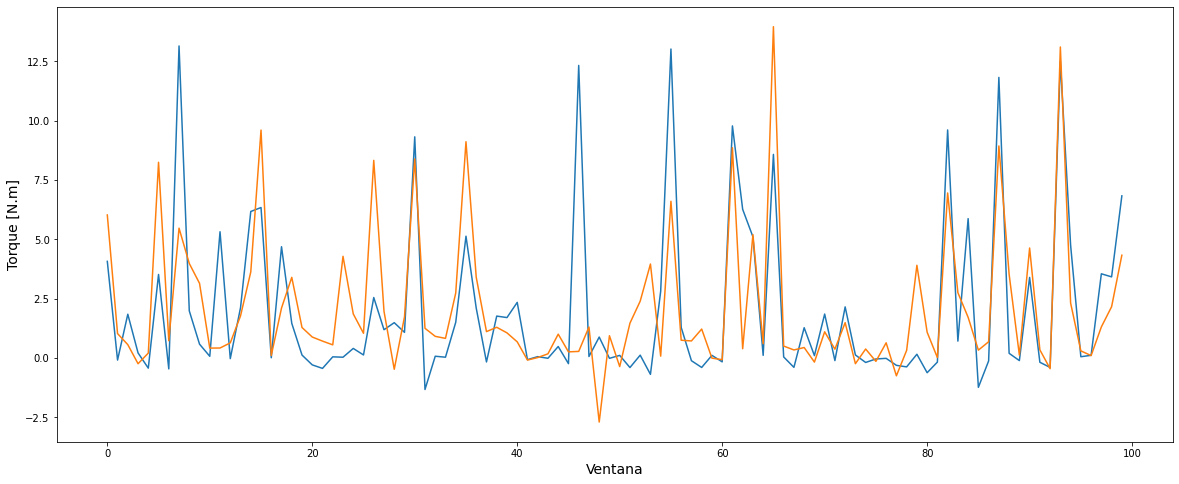

In [95]:
predicted = deep_mlp.predict(X_test_feat)
n = 100
plt.figure(figsize=(20,8))
plt.plot(Y_test_feat[0:n])
plt.plot(predicted[0:n])
plt.ylabel("Torque [N.m]", fontsize=14)
plt.xlabel("Ventana", fontsize=14)

In [96]:
w_length = 200
w_increment = 100

path = 'D:\Documentos\Datasets\Grabaciones 3 Corr'

raw_data, labels, angle, speed, torque = loadAndLabel(path, w_length, w_increment)

1_ext2_0_30_74.txt
1_ext_0_30_74.txt
1_ext_1150_30_74.txt
1_ext_2300_30_74.txt
1_flex_1150_30_74.txt
1_flex_2300_30_74.txt
1_flex_3300_30_74.txt
1_flex_4300_30_74.txt
1_pron_1150_5_74.txt
1_pron_2300_5_74.txt
1_pron_3300_5_74.txt
1_stat_0_30_74.txt
1_sup_0_5_74.txt
1_sup_1150_5_74.txt
1_sup_2300_5_74.txt
1_sup_3300_5_74.txt


In [97]:
emg_raw_arr = np.array(raw_data)[:,:,0:4]
labels_arr = np.array(labels)
angle_arr = np.array(angle)
speed_arr = np.array(speed)
torque_arr = np.array(torque)
print(emg_raw_arr.shape)

(6949, 200, 4)


In [98]:
f_emg_data = EMGfeatures(emg_raw_arr)

sc = MinMaxScaler()
trans = sc.fit_transform(f_emg_data)

print(f_emg_data.shape)

c:\Users\alejo\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\signal\_spectral_py.py:1999: UserWarning: nperseg = 256 is greater than input length  = 200, using nperseg = 200
  warnings.warn('nperseg = {0:d} is greater than input length '


(6949, 44)


In [100]:
deep_mlp.evaluate(f_emg_data,torque_arr)

218/218 [==============================] - 0s 2ms/step - loss: 9.8988 - mean_absolute_error: 2.2122 - mean_squared_error: 9.8988 - root_mean_squared_error: 3.1462


[9.89880657196045, 2.21219801902771, 9.89880657196045, 3.1462368965148926]

218/218 [==============================] - 0s 957us/step


Text(0.5, 0, 'Ventana')

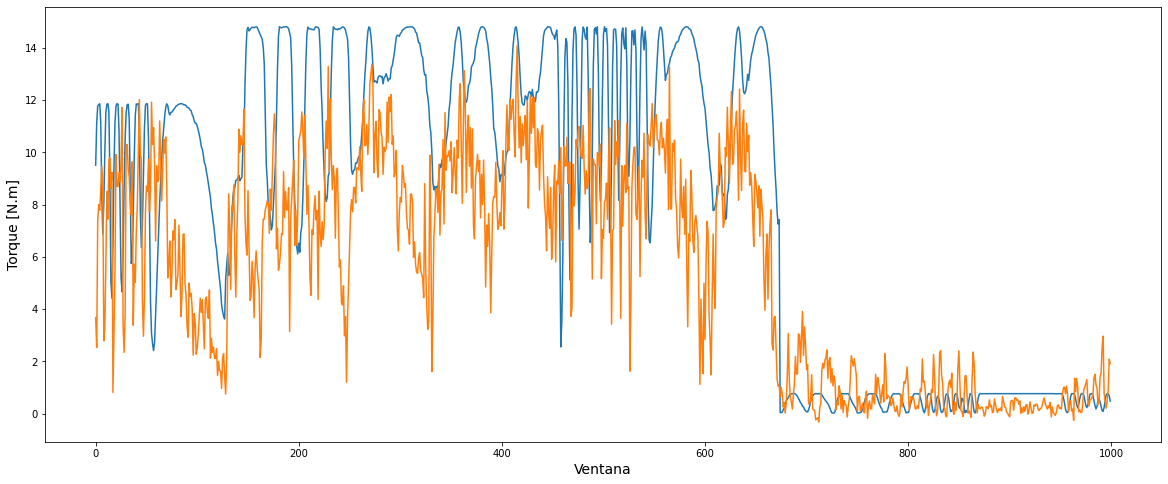

In [102]:
predicted = deep_mlp.predict(f_emg_data)
n = 5000
plt.figure(figsize=(20,8))
plt.plot(torque_arr[4000:n])
plt.plot(predicted[4000:n])
plt.ylabel("Torque [N.m]", fontsize=14)
plt.xlabel("Ventana", fontsize=14)

# Speed Regression Training

In [13]:
X_train_feat, X_test_feat, Y_train_feat, Y_test_feat = train_test_split(f_emg_data, speed_arr, stratify=labels, test_size=0.1, random_state=1)

X_train_maf, X_test_maf, Y_train_maf, Y_test_maf = train_test_split(maf_emg_data, speed_arr, stratify=labels, test_size=0.1, random_state=1)
X_train_maf_flat, X_test_maf_flat, Y_train_maf_flat, Y_test_maf_flat = train_test_split(maf_emg_data_flat, speed_arr, stratify=labels, test_size=0.1, random_state=1)

X_train_ae, X_test_ae, Y_train_ae, Y_test_ae = train_test_split(ae_emg_data, speed_arr, stratify=labels, test_size=0.1, random_state=1)
X_train_ae_flat, X_test_ae_flat, Y_train_ae_flat, Y_test_ae_flat = train_test_split(ae_emg_data_flat, speed_arr, stratify=labels, test_size=0.1, random_state=1)

## EMG Features

In [39]:
models_reg, models_names_reg = sklearnModelsReg()
train_scores, val_scores = cvRegression(X_train_feat, Y_train_feat, Y_train_labels, models_reg, k=5)

c:\Users\alejo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\alejo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\alejo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\alejo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

In [ ]:
mlp_train_scores, mlp_val_scores = cvKerasReg(X_train_feat, Y_train_feat, Y_train_labels, mlpReg(), k = 5)
models_names_reg.append('Deep MLP')
train_scores[0].append(mlp_train_scores[0])
train_scores[1].append(mlp_train_scores[1])
train_scores[2].append(mlp_train_scores[2])
val_scores[0].append(mlp_val_scores[0])
val_scores[1].append(mlp_val_scores[1])
val_scores[2].append(mlp_val_scores[2])

In [41]:
cols = pd.MultiIndex.from_product([['Train', 'Val'], ['MAE', 'MSE', 'R2']],names=['','Model'])
models_comparison_reg = pd.DataFrame(zip(train_scores[0], train_scores[1], train_scores[2], val_scores[0], val_scores[1], val_scores[2]), index=models_names_reg, columns=cols)
models_comparison_reg = models_comparison_reg.sort_values([('Val', 'MAE')], ascending=True)
models_comparison_reg


Train                                 Val  \
Model                       MAE           MSE        R2         MAE   
Random Forest      4.338806e+01  3.861509e+03  0.917684  116.589585   
Bagging            4.909369e+01  5.570020e+03  0.881264  123.212217   
Gradient Boosting  1.336217e+02  3.172032e+04  0.323816  137.600933   
Deep MLP           1.367194e+02  3.317635e+04  0.292724  138.396985   
MLP                1.431723e+02  3.597224e+04  0.233177  144.039275   
Stacking           9.693953e+01  1.577124e+04  0.663802  144.368239   
Linear Regression  1.497409e+02  3.853822e+04  0.178479  149.991757   
Decision Tree      8.775401e-15  2.079716e-27  1.000000  151.779064   
AdaBoost           1.516680e+02  3.798319e+04  0.190311  152.653855   
KNN                1.268979e+02  2.860454e+04  0.390235  156.116883   
SVM                1.583904e+02  4.338151e+04  0.075234  158.445490   

                                           
Model                       MSE        R2  
Random Forest      27479.825593  0.414135  
Bagging            30396.025400  0.351957  
Gradient Boosting  33603.343569  0.283583  
Deep MLP           33974.425781  0.275780  
MLP                36367.419116  0.224664  
Stacking           36697.741014  0.217623  
Linear Regression  38692.515674  0.175091  
Decision Tree      58523.380947 -0.247687  
AdaBoost           38675.504286  0.175444  
KNN                43101.868775  0.081096  
SVM                43397.063018  0.074786

## Moving Average Filter

In [42]:
train_scores = [[],[],[]]
val_scores = [[],[],[]]
models_names_reg = []

In [43]:
mlp_train_scores, mlp_val_scores = cvKerasReg(X_train_maf_flat, Y_train_maf_flat, Y_train_labels, mlpReg(), k = 5)
models_names_reg.append('Deep MLP')
train_scores[0].append(mlp_train_scores[0])
train_scores[1].append(mlp_train_scores[1])
train_scores[2].append(mlp_train_scores[2])
val_scores[0].append(mlp_val_scores[0])
val_scores[1].append(mlp_val_scores[1])
val_scores[2].append(mlp_val_scores[2])

Epoch 1/200
64/64 [==============================] - 0s 3ms/step - loss: 66245.7344 - mean_absolute_error: 195.7620 - mean_squared_error: 66245.7344
Epoch 2/200
64/64 [==============================] - 0s 3ms/step - loss: 60280.8477 - mean_absolute_error: 184.5022 - mean_squared_error: 60280.8477
Epoch 3/200
64/64 [==============================] - 0s 3ms/step - loss: 51370.7461 - mean_absolute_error: 169.2339 - mean_squared_error: 51370.7461
Epoch 4/200
64/64 [==============================] - 0s 3ms/step - loss: 47158.1055 - mean_absolute_error: 164.7747 - mean_squared_error: 47158.1055
Epoch 5/200
64/64 [==============================] - 0s 3ms/step - loss: 46609.1328 - mean_absolute_error: 164.4234 - mean_squared_error: 46609.1328
Epoch 6/200
64/64 [==============================] - 0s 3ms/step - loss: 46414.4336 - mean_absolute_error: 164.1542 - mean_squared_error: 46414.4336
Epoch 7/200
64/64 [==============================] - 0s 2ms/step - loss: 46243.8398 - mean_absolute_error:

In [44]:
cnn_train_scores, cnn_val_scores = cvKerasReg(X_train_maf.reshape(X_train_maf.shape[0],w,ch,1), Y_train_maf, Y_train_labels, cnnReg(), k = 5)
models_names_reg.append('CNN')
train_scores[0].append(cnn_train_scores[0])
train_scores[1].append(cnn_train_scores[1])
train_scores[2].append(cnn_train_scores[2])
val_scores[0].append(cnn_val_scores[0])
val_scores[1].append(cnn_val_scores[1])
val_scores[2].append(cnn_val_scores[2])

Epoch 1/200
64/64 [==============================] - 1s 6ms/step - loss: 66569.9062 - mean_absolute_error: 196.4548 - mean_squared_error: 66569.9062
Epoch 2/200
64/64 [==============================] - 0s 5ms/step - loss: 49087.3359 - mean_absolute_error: 172.4558 - mean_squared_error: 49087.3359
Epoch 3/200
64/64 [==============================] - 0s 5ms/step - loss: 44376.0039 - mean_absolute_error: 168.7821 - mean_squared_error: 44376.0039
Epoch 4/200
64/64 [==============================] - 0s 5ms/step - loss: 44261.2461 - mean_absolute_error: 168.3526 - mean_squared_error: 44261.2461
Epoch 5/200
64/64 [==============================] - 0s 5ms/step - loss: 44183.8438 - mean_absolute_error: 168.1549 - mean_squared_error: 44183.8438
Epoch 6/200
64/64 [==============================] - 0s 5ms/step - loss: 44130.7266 - mean_absolute_error: 167.8137 - mean_squared_error: 44130.7266
Epoch 7/200
64/64 [==============================] - 0s 5ms/step - loss: 44098.5117 - mean_absolute_error:

In [45]:
lstm_train_scores, lstm_val_scores = cvKerasReg(X_train_maf, Y_train_maf, Y_train_labels, lstm_rnnReg(), k = 5)
models_names_reg.append('LSTM')
train_scores[0].append(lstm_train_scores[0])
train_scores[1].append(lstm_train_scores[1])
train_scores[2].append(lstm_train_scores[2])
val_scores[0].append(lstm_val_scores[0])
val_scores[1].append(lstm_val_scores[1])
val_scores[2].append(lstm_val_scores[2])

Epoch 1/200
64/64 [==============================] - 2s 15ms/step - loss: 67178.9375 - mean_absolute_error: 197.5163 - mean_squared_error: 67178.9375
Epoch 2/200
64/64 [==============================] - 1s 13ms/step - loss: 64088.2383 - mean_absolute_error: 192.1107 - mean_squared_error: 64088.2383
Epoch 3/200
64/64 [==============================] - 1s 14ms/step - loss: 59428.6328 - mean_absolute_error: 184.3242 - mean_squared_error: 59428.6328
Epoch 4/200
64/64 [==============================] - 1s 14ms/step - loss: 54920.6484 - mean_absolute_error: 177.3521 - mean_squared_error: 54920.6484
Epoch 5/200
64/64 [==============================] - 1s 13ms/step - loss: 51230.4414 - mean_absolute_error: 173.2895 - mean_squared_error: 51230.4414
Epoch 6/200
64/64 [==============================] - 1s 13ms/step - loss: 48778.1602 - mean_absolute_error: 172.2105 - mean_squared_error: 48778.1602
Epoch 7/200
64/64 [==============================] - 1s 14ms/step - loss: 47473.3320 - mean_absolute

In [46]:
gru_train_scores, gru_val_scores = cvKerasReg(X_train_maf, Y_train_maf, Y_train_labels, gru_rnnReg(), k = 5)
models_names_reg.append('GRU')
train_scores[0].append(gru_train_scores[0])
train_scores[1].append(gru_train_scores[1])
train_scores[2].append(gru_train_scores[2])
val_scores[0].append(gru_val_scores[0])
val_scores[1].append(gru_val_scores[1])
val_scores[2].append(gru_val_scores[2])

Epoch 1/200
64/64 [==============================] - 3s 20ms/step - loss: 66882.8906 - mean_absolute_error: 196.9831 - mean_squared_error: 66882.8906
Epoch 2/200
64/64 [==============================] - 1s 18ms/step - loss: 62527.5508 - mean_absolute_error: 189.3563 - mean_squared_error: 62527.5508
Epoch 3/200
64/64 [==============================] - 1s 18ms/step - loss: 58384.1211 - mean_absolute_error: 182.6689 - mean_squared_error: 58384.1211
Epoch 4/200
64/64 [==============================] - 1s 18ms/step - loss: 54582.0273 - mean_absolute_error: 176.8584 - mean_squared_error: 54582.0273
Epoch 5/200
64/64 [==============================] - 1s 18ms/step - loss: 51396.2148 - mean_absolute_error: 173.4117 - mean_squared_error: 51396.2148
Epoch 6/200
64/64 [==============================] - 1s 17ms/step - loss: 49116.0039 - mean_absolute_error: 172.2003 - mean_squared_error: 49116.0039
Epoch 7/200
64/64 [==============================] - 1s 18ms/step - loss: 47744.3633 - mean_absolute

In [47]:
cols = pd.MultiIndex.from_product([['Train', 'Val'], ['MAE', 'MSE', 'R2']],names=['','Model'])
models_comparison_reg = pd.DataFrame(zip(train_scores[0], train_scores[1], train_scores[2], val_scores[0], val_scores[1], val_scores[2]), index=models_names_reg, columns=cols)
models_comparison_reg = models_comparison_reg.sort_values([('Val', 'MAE')], ascending=True)
models_comparison_reg

Train                                 Val                \
Model            MAE           MSE        R2         MAE           MSE   
CNN       143.745786  35878.007812  0.235124  146.062903  37119.643750   
LSTM      144.489661  36472.227344  0.222440  146.185043  37338.397656   
Deep MLP  142.789957  35901.654687  0.234625  146.684189  37693.828125   
GRU       145.589301  36631.729688  0.219074  146.896927  37368.212500   

                    
Model           R2  
CNN       0.208719  
LSTM      0.204181  
Deep MLP  0.196489  
GRU       0.203457

## Autoencoder Feature Extraction

In [48]:
train_scores = [[],[],[]]
val_scores = [[],[],[]]
models_names_reg = []

In [ ]:
mlp_train_scores, mlp_val_scores = cvKerasReg(X_train_ae_flat, Y_train_ae_flat, Y_train_labels, mlpReg(), k = 5)
models_names_reg.append('Deep MLP')
train_scores[0].append(mlp_train_scores[0])
train_scores[1].append(mlp_train_scores[1])
train_scores[2].append(mlp_train_scores[2])
val_scores[0].append(mlp_val_scores[0])
val_scores[1].append(mlp_val_scores[1])
val_scores[2].append(mlp_val_scores[2])

In [ ]:
cnn_train_scores, cnn_val_scores = cvKerasReg(X_train_ae.reshape(X_train_ae.shape[0],X_train_ae.shape[1],X_train_ae.shape[2],1), Y_train_ae, Y_train_labels, cnnReg(), k = 5)
models_names_reg.append('CNN')
train_scores[0].append(cnn_train_scores[0])
train_scores[1].append(cnn_train_scores[1])
train_scores[2].append(cnn_train_scores[2])
val_scores[0].append(cnn_val_scores[0])
val_scores[1].append(cnn_val_scores[1])
val_scores[2].append(cnn_val_scores[2])

In [ ]:
lstm_train_scores, lstm_val_scores = cvKerasReg(X_train_ae, Y_train_ae, Y_train_labels, lstm_rnnReg(), k = 5)
models_names_reg.append('LSTM')
train_scores[0].append(lstm_train_scores[0])
train_scores[1].append(lstm_train_scores[1])
train_scores[2].append(lstm_train_scores[2])
val_scores[0].append(lstm_val_scores[0])
val_scores[1].append(lstm_val_scores[1])
val_scores[2].append(lstm_val_scores[2])

In [ ]:
gru_train_scores, gru_val_scores = cvKerasReg(X_train_ae, Y_train_ae, Y_train_labels, gru_rnnReg(), k = 5)
models_names_reg.append('GRU')
train_scores[0].append(gru_train_scores[0])
train_scores[1].append(gru_train_scores[1])
train_scores[2].append(gru_train_scores[2])
val_scores[0].append(gru_val_scores[0])
val_scores[1].append(gru_val_scores[1])
val_scores[2].append(gru_val_scores[2])

In [ ]:
cols = pd.MultiIndex.from_product([['Train', 'Val'], ['MAE', 'MSE', 'R2']],names=['','Model'])
models_comparison_reg = pd.DataFrame(zip(train_scores[0], train_scores[1], train_scores[2], val_scores[0], val_scores[1], val_scores[2]), index=models_names_reg, columns=cols)
models_comparison_reg = models_comparison_reg.sort_values([('Val', 'MAE')], ascending=True)
models_comparison_reg

# Independent Models

In [76]:
fe_f_emg_data = [f_emg_data[i] for i,v in enumerate(labels) if v < 3]
fe_torque = [torque[i] for i,v in enumerate(labels) if v < 3]

fe_f_emg_data = np.array(fe_f_emg_data)
fe_torque_arr = np.array(fe_torque)
print(fe_f_emg_data.shape)
print(fe_torque_arr.shape)

(4958, 44)
(4958,)


In [80]:
X_train_feat, X_test_feat, Y_train_feat, Y_test_feat = train_test_split(fe_f_emg_data, fe_torque_arr, test_size=0.1, shuffle=True)
deep_mlp = mlpReg()
deep_mlp.compile(optimizer='adam', loss='mean_squared_error', metrics=['MeanAbsoluteError','MeanSquaredError','RootMeanSquaredError','MeanAbsolutePercentageError'])
deep_mlp.fit(x=X_train_feat, y=Y_train_feat, epochs=1000, batch_size=256)

Epoch 1/1000
18/18 [==============================] - 0s 3ms/step - loss: 16.1723 - mean_absolute_error: 3.2226 - mean_squared_error: 16.1723 - root_mean_squared_error: 4.0215 - mean_absolute_percentage_error: 460.3038
Epoch 2/1000
18/18 [==============================] - 0s 3ms/step - loss: 9.5100 - mean_absolute_error: 2.3628 - mean_squared_error: 9.5100 - root_mean_squared_error: 3.0838 - mean_absolute_percentage_error: 288.6642
Epoch 3/1000
18/18 [==============================] - 0s 3ms/step - loss: 7.8217 - mean_absolute_error: 2.0907 - mean_squared_error: 7.8217 - root_mean_squared_error: 2.7967 - mean_absolute_percentage_error: 237.9690
Epoch 4/1000
18/18 [==============================] - 0s 3ms/step - loss: 6.6557 - mean_absolute_error: 1.9031 - mean_squared_error: 6.6557 - root_mean_squared_error: 2.5799 - mean_absolute_percentage_error: 209.8798
Epoch 5/1000
18/18 [==============================] - 0s 3ms/step - loss: 5.9835 - mean_absolute_error: 1.7926 - mean_squared_erro

In [81]:
deep_mlp.evaluate(X_train_feat,Y_train_feat)
deep_mlp.evaluate(X_test_feat,Y_test_feat)

16/16 [==============================] - 0s 3ms/step - loss: 4.1608 - mean_absolute_error: 1.3318 - mean_squared_error: 4.1608 - root_mean_squared_error: 2.0398 - mean_absolute_percentage_error: 94.9933


[4.160818099975586,
 1.3317975997924805,
 4.160818099975586,
 2.0398082733154297,
 94.99331665039062]

16/16 [==============================] - 0s 941us/step


Text(0.5, 0, 'Ventana')

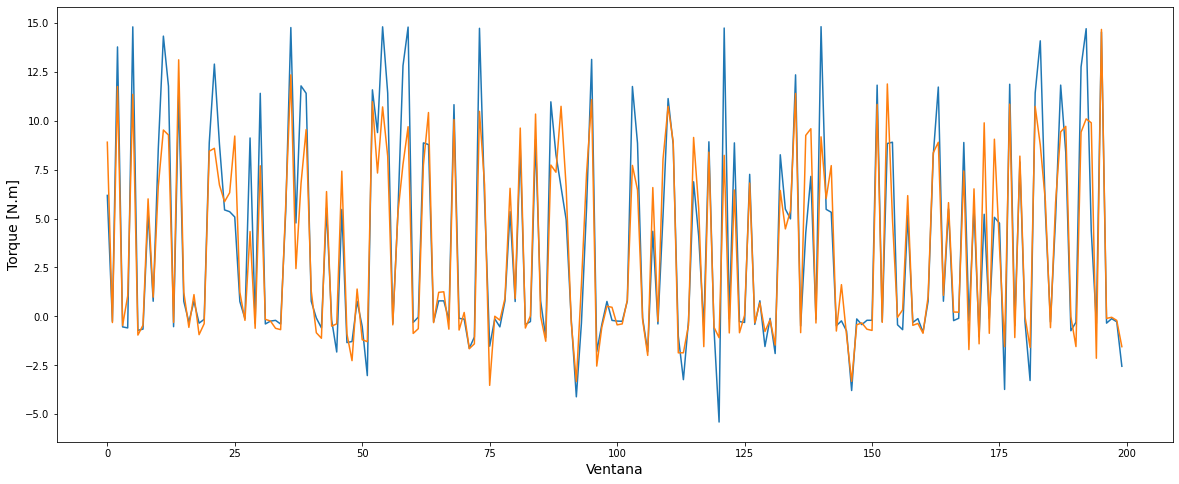

In [82]:
predicted = deep_mlp.predict(X_test_feat)
n = 200
plt.figure(figsize=(20,8))
plt.plot(Y_test_feat[0:n])
plt.plot(predicted[0:n])
plt.ylabel("Torque [N.m]", fontsize=14)
plt.xlabel("Ventana", fontsize=14)